In [40]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from dgl import load_graphs
import sys
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.manifold import TSNE

# Load Needed

In [24]:
with open('sample_recommendations.json') as woahs:
     woah = json.load(woahs)

In [25]:
with open('uri_recs_170k.json', 'r') as yuh:
    uri_map = json.load(yuh)

In [26]:
data_path = (os.path.join(os.path.expanduser('~'), 'GNN-Spotify-Recommender-Project/data/a13group1/double_edges_170k.bin'))

In [27]:
dgl_G = load_graphs(data_path)[0][0]

# Song Connectivity Within Recommendation

In [28]:
%%time
in_rec_accs = []
for i in range(len(woah)):
    res = list(combinations(woah[i]['recs'], 2))

    checks = []
    for pair in res:
        check = uri_map[pair[0]] in dgl_G.out_edges(uri_map[pair[1]])[1]
        checks.append(check)
        
    in_rec_accs.append(np.count_nonzero(checks) / len(checks))

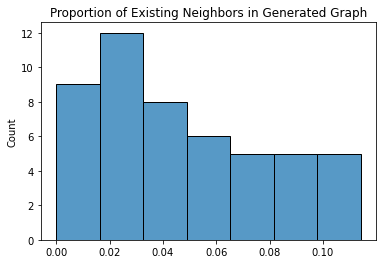

In [29]:
sns.histplot(in_rec_accs).set(title=f'Proportion of Existing Neighbors in Generated Graph')
plt.savefig('rec_connectivity.jpg')

# Feature Distribution

In [41]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

edafeats = pd.read_csv(os.path.join(os.path.expanduser('~'), 'GNN-Spotify-Recommender-Project/data/a13group1/songset_features_170k'))
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [42]:
def get_distribution(edafeats, uri_recs):
    numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
    categorical = ['key', 'mode', 'time_signature']

    feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

    for i in numerical:
        cur_feats = edafeats[edafeats['id'].isin(uri_recs)]

        var = np.var(cur_feats[i])
        feat_vars[i] = (var)

        avg = np.mean(cur_feats[i])
        feat_avgs[i] = (avg)

        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i] = difs

        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i] = ranges

    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i] = highest

    feat_avgs.pop('key')
    feat_avgs.pop('mode')
    feat_avgs.pop('time_signature')

    feat_difs.pop('key')
    feat_difs.pop('mode')
    feat_difs.pop('time_signature')

    feat_ranges.pop('key')
    feat_ranges.pop('mode')
    feat_ranges.pop('time_signature')
    
    return feat_vars, feat_avgs, feat_difs, feat_ranges

In [43]:
%%time
# Get original playlists and recommendations for them.
# Saving sample of playlists
original_playlists = []
generated_playlists = []
for i in range(len(woah)):
    saved_seeds = woah[i]['seeds']
    saved_recs = woah[i]['recs']
    
    original_playlists.append(saved_seeds)
    generated_playlists.append(saved_recs)

CPU times: user 66 µs, sys: 9 µs, total: 75 µs
Wall time: 93.9 µs


In [44]:
%%time
# Will get the variances from originals and generated.
# Saves the differences between the variances for each playlist/generated playlist
size = len(original_playlists)
differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in range(size):
    feat_vars_og, feat_avgs_og, feat_difs_og, feat_ranges_og = get_distribution(edafeats, original_playlists[i])
    feat_vars_gen, feat_avgs_gen, feat_difs_gen, feat_ranges_gen = get_distribution(edafeats, generated_playlists[i])
    
    for each in differences.keys():
        differences[each].append(np.abs(feat_vars_og[each] - feat_vars_gen[each]))

CPU times: user 10.8 s, sys: 242 ms, total: 11 s
Wall time: 11 s


In [45]:
# Gets the average difference in variance for each feature
avg_differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in avg_differences.keys():
    avg_differences[i] = np.mean(np.array(differences[i]))

In [46]:
avg_differences

{'danceability': 0.008096921339389303,
 'energy': 0.012820774845462955,
 'loudness': 0.26852720568686406,
 'speechiness': 0.04713902211636237,
 'acousticness': 0.025934200506381663,
 'instrumentalness': 0.011154315593824111,
 'liveness': 0.04722225008297361,
 'valence': 0.013581795970573875,
 'tempo': 0.6136293338178255,
 'duration_ms': 0.6790665090610356,
 'key': 0.06953309483017969,
 'mode': 0.0896974067182766,
 'time_signature': 0.07262263814658494}

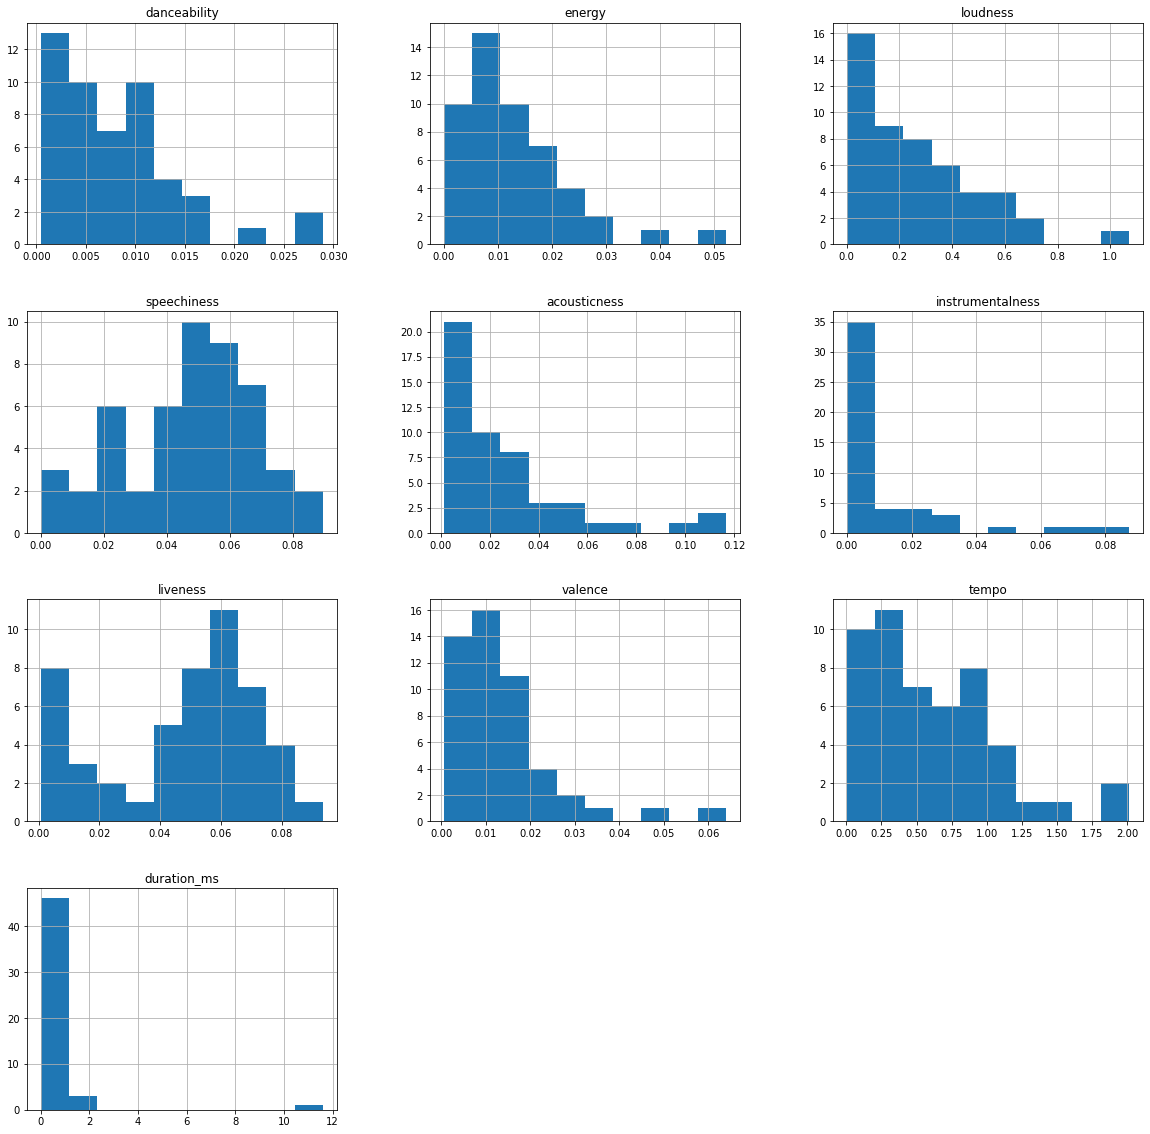

In [47]:
# Plots the differences for each feature
pd.DataFrame(differences)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))
plt.savefig('var_differences.jpg')

# Embedding T-SNE
Will require training of the model

In [ ]:
# %%time
# # Loading Graph ~ 3min
# feat_dir = "../../data/a13group1/features/merged_features.csv"
# double_edge_dir = "../../data/a13group1/double_edges_170k.bin"
# feat_data, adj_list, dgl_G, uri_map = r.load_double_edge(feat_dir, double_edge_dir)

In [ ]:
# %%time
# # Training the Model. GPU ~ 00:00:40
# with open('../../config/model-params.json') as fh:
#             model_cfg = json.load(fh)
# model, pred = train(dgl_G, feat_data, adj_list, **model_cfg)

# # Put everything on CPU
# model = model.to('cpu')
# pred = pred.to('cpu')

In [ ]:
# # Create Embeddings
# z = model(dgl_G, feat_data)

# # Create Predictions
# # In the form of the strength of the connection between source, destination from dgl_G.edges()
# preds = pred(dgl_G, z)

### T-SNE

In [ ]:
# # Instantialte tsne, specify cosine metric
# tsne = TSNE(n_iter = 1000, metric = 'cosine', square_distances=True)

In [ ]:
# %%time
# ## WARNING -- AROUND 30 MINUTES TO COMPLETE
# embeddings2d = tsne.fit_transform(z.detach().numpy())

In [ ]:
# # Create DF
# embeddingsdf = pd.DataFrame()
# # Add game names
# embeddingsdf['id'] = edafeats['id']
# # Add x coordinate
# embeddingsdf['x'] = embeddings2d[:,0]
# # Add y coordinate
# embeddingsdf['y'] = embeddings2d[:,1]
# # Check
# embeddingsdf.head()


In [ ]:
# # Set figsize
# fig, ax = plt.subplots(figsize=(10,8))
# # Scatter points, set alpha low to make points translucent
# ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.01)
# plt.title('Scatter plot of Song Embeddings T-SNE')
# plt.savefig('embedding_tsne.jpg')
# plt.show()